In this notebook, we will examine what piezoelectricity is, using a simple model.

# A simple model with 6 charges 

We need charged particles to compute electric fields. Let's build some classes for this:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class ChargedParticle:
    def __init__(self, pos, charge):
        self.pos = np.asarray(pos)
        self.charge = charge
        
    def compute_field(self, x, y):
        X, Y = np.meshgrid(x, y)
        u_i = np.hstack((X.ravel()[:, np.newaxis],  Y.ravel()[:, np.newaxis])) - self.pos
        r = np.sqrt((X - self.pos[0])**2 + (Y - self.pos[1])**2)
        field = ((self.charge * 9e9 / r**2).ravel()[:, np.newaxis] * u_i).reshape(X.shape + (2,))
        return field
    
    def plot_particle(self, ax):
        if self.charge > 0:
            ax.plot(self.pos[0], self.pos[1], 'or')
        else:
            ax.plot(self.pos[0], self.pos[1], 'ok')

Let's build a crystal and its charges:

In [3]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 80)
Y, X = np.meshgrid(x, y)

Let's now build a couple of charges:

In [4]:
def compute_resulting_field(particles, x, y):
    fields = [p.compute_field(x, y) for p in particles]
    total_field = np.zeros_like(fields[0])
    for field in fields:
        total_field += field
    return total_field

In [5]:
N = 6
particles = [ChargedParticle((np.cos(2 * np.pi / N * i), np.sin(2 * np.pi / N * i)), 
                             (((i + 1) % 2) * 2 - 1)) for i in range(N)]

In [6]:
[(((i + 1) % 2) * 2 - 1) for i in range(N)]

[1, -1, 1, -1, 1, -1]

In [7]:
total_field = compute_resulting_field(particles, x, y)

To represent the resulting electric field, we will use the `plt.streamplot` feature. We will also plot streamline thicknesses that depends on the maximum field amplitude.

In [8]:
lw = np.linalg.norm(total_field, axis=2)
lw /= lw.max()

In [9]:
VMAX = 0.5e11

(-2.0, 2.0)

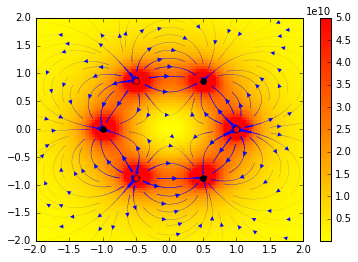

In [10]:
ax = plt.gca()
plt.pcolormesh(x, y, np.linalg.norm(total_field, axis=2), cmap=plt.cm.autumn_r, vmax=VMAX)
plt.colorbar()
plt.streamplot(x, y, total_field[:, :, 0], total_field[:, :, 1], color='blue',
               linewidth=10*lw)
for particle in particles:
    particle.plot_particle(ax)
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())

What happens if the particles get now compressed through the movement of the lattice?

In [11]:
particles = [ChargedParticle((np.cos(2 * np.pi / N * i), np.sin(2 * np.pi / N * i) * 0.7), 
                             (((i + 1) % 2) * 2 - 1)) for i in range(N)]

In [12]:
total_field = compute_resulting_field(particles, x, y)

(-2.0, 2.0)

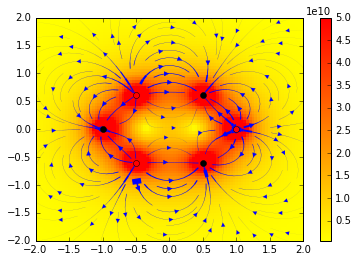

In [13]:
ax = plt.gca()
plt.pcolormesh(x, y, np.linalg.norm(total_field, axis=2), cmap=plt.cm.autumn_r, vmax=VMAX)
plt.colorbar()
plt.streamplot(x, y, total_field[:, :, 0], total_field[:, :, 1], color='blue',
               linewidth=10*lw)
for particle in particles:
    particle.plot_particle(ax)
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())

In this configuration (deformed configuration), a nonzero bias of the field appears on the axis: an electric field from left to right is created by deforming the position of the atoms. From afar, this field can be represented, at larger space scales, by a [dipole](http://hyperphysics.phy-astr.gsu.edu/hbase/electric/dipole.html). We will see how we can do that in the next section.

But first, let's do an animation to see that the larger the displacement gets, the bigger the electric bias field on the axis gets.

In [14]:
from tempfile import NamedTemporaryFile
import base64 
from matplotlib import animation
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        f = NamedTemporaryFile(suffix='.mp4', delete=False)
        anim.save(f.name, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
        f.flush()
        video = open(f.name, "rb").read()
        f.close()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    
    return VIDEO_TAG.format(anim._encoded_video)

In [15]:
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [16]:
import matplotlib as mpl

In [19]:
FRAMES = 25
fig = plt.figure()
ax = fig.add_subplot(111)
cax, kw = mpl.colorbar.make_axes(parents=ax, location='right')

# animation function.  This is called sequentially
def animate(i):
    current_displacement = np.linspace(1, 0.1, num=FRAMES)[i]
    particles = [ChargedParticle((np.cos(2 * np.pi / N * j), np.sin(2 * np.pi / N * j) * current_displacement), 
                             (((j + 1) % 2) * 2 - 1)) for j in range(N)]
    total_field = compute_resulting_field(particles, x, y)
    ax.cla()
    pcm = ax.pcolormesh(x, y, np.linalg.norm(total_field, axis=2), cmap=plt.cm.autumn_r, vmax=VMAX)
    if i == 0:
        print(pcm)
        #import pdb; pdb.set_trace()
        fig.colorbar(pcm, ax=ax, cax=cax)
    ax.streamplot(x, y, total_field[:, :, 0], total_field[:, :, 1], color='blue',
               linewidth=10*lw)
    for particle in particles:
        particle.plot_particle(ax)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())

# call the animator.
anim = animation.FuncAnimation(fig, animate, init_func=lambda : None,
                               frames=FRAMES, interval=125)

# call our new function to display the animation
display_animation(anim)

The interpretation of this animation is interesting: the closer the charges get compressed, the more the field looks like a dipole field. To emphasize this resemblance, we will look at a dipole field in the next section.

While making the above animation, I had trouble to get the axes right. In particular, I learnt that the `colorbar` method needs to be called on a figure and not on axes, because if it does, the it calls `gcf()` which generates a spurious element in the animation.

# From simple charges to a dipole 

Let's plot a dipole field, in the same manner as above, but only with two particles:

In [23]:
particles = [ChargedParticle([-0.5, 0], 1),
            ChargedParticle([0.5, 0], -1)]

In [24]:
total_field = compute_resulting_field(particles, x, y)

(-2.0, 2.0)

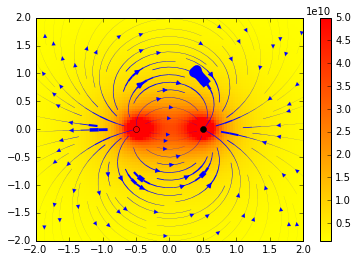

In [25]:
ax = plt.gca()
plt.pcolormesh(x, y, np.linalg.norm(total_field, axis=2), cmap=plt.cm.autumn_r, vmax=VMAX)
plt.colorbar()
plt.streamplot(x, y, total_field[:, :, 0], total_field[:, :, 1], color='blue',
               linewidth=10*lw)
for particle in particles:
    particle.plot_particle(ax)
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())

From afar, the previous arrangement of atoms looks indeed like a dipole. So we can replace the previous crystallographic arrangement by a dipole and zoom up one scale.